In [143]:
from dask.array.image import imread as imr
import os
import numpy as np
import matplotlib.pyplot as plt
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
from runBigfishDetection import saveSpotsNPZ, reorderZstack
from bigfish.detection.utils import get_object_radius_pixel


In [144]:
import tifffile
from imaris_ims_file_reader.ims import ims

In [51]:
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


In [52]:
print("numoy version: {0}".format(np.__version__))

numoy version: 1.23.0


In [107]:
voxelRadius = (600, 121, 121)
objectRadius = (600, 105, 105)

In [5]:
# timePoint = 722
# # imagePath = '/media/rachel/Hussein EBL/20230720/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F11.ims'
# # imagePath = '/media/rachel/Hussein EBL/20230629/Hela_h9_h2_k11_mcpsg_basal_001_F01.ims'

# imsData = ims(imagePath)

In [13]:
# tFrame = imsData[timePoint,:,:,:,:]
# tFrameShape = tFrame.shape

In [6]:
# tFrame.shape

In [150]:
homeFolder = '/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/'
nameKey = 'Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F'
# homeFolder = '/home/rachel/single/spinningSequence/'
# nameKey = 'hela_K11_ON-_F'
imsQ = '10'
pathToTimeFrames = homeFolder+nameKey+imsQ+'/*.tif'
cellNumber = '4'
path_input = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
nucleiStackForm = nameKey+imsQ+"_cell_"
pathToTimeFramesCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'
stackCell = imr(pathToTimeFramesCell)
MaxTimePoint = stackCell.shape[0]
path_input

'/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F10/cell_4/'

## Using 

Total number of images : 90
Detected threshold:782.0


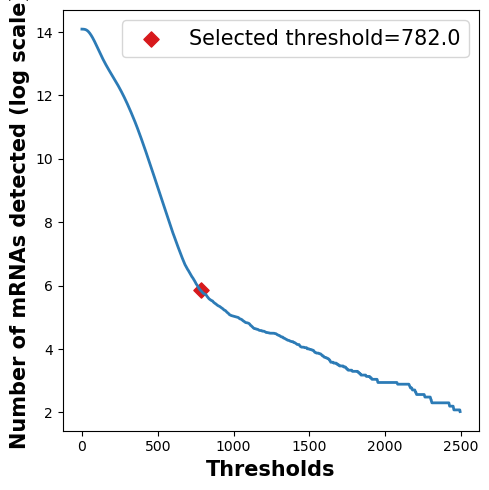

In [151]:
rna_list = []
spots_list=[]
MaxTimePoint = 900
for t in range(0,MaxTimePoint,10):

    path = os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif")
    rna_all = stack.read_image(path)
    rna = reorderZstack(rna_all,4)
    #rna = rna[:11]
    rna_mip = stack.maximum_projection(rna)
    rna_list.append(rna)

images=rna_list
n=len(images)
print("Total number of images : "+str(n))

spots_image_list, threshold_image_list = detection.detect_spots(
    images=images, 
    return_threshold=True, 
    voxel_size=voxelRadius,  # in nanometer (one value per dimension zyx)
    spot_radius=objectRadius)  # in nanometer (one value per dimension zyx)

print('Detected threshold:'+str(threshold_image_list))
plot.plot_elbow(
    images=images, 
    voxel_size=voxelRadius, 
    spot_radius=objectRadius)


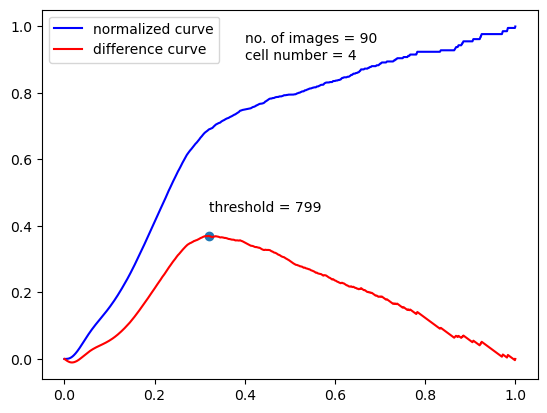

In [152]:
kernel_size=None
voxel_size=voxelRadius
spot_radius=objectRadius

gamma=4
ndim=3
image=rna
# get gaussian kernel to denoise the image
if kernel_size is None and gamma > 0:
    spot_radius_px = get_object_radius_pixel(
        voxel_size_nm=voxel_size,
        object_radius_nm=spot_radius,
        ndim=ndim)
    kernel_size = tuple([spot_radius_px_ * gamma
                         for spot_radius_px_ in spot_radius_px])

# denoise the image
if kernel_size is not None:
    image_denoised = stack.remove_background_gaussian(
        image=image,
        sigma=kernel_size)

thresholds, count_spots, threshold = detection.get_elbow_values(
        rna_list,
        voxel_size=voxel_size,
        spot_radius=spot_radius)

x=thresholds
y=count_spots

from kneed import KneeLocator
knees = []
norm_knees = []

kneedle = KneeLocator(
    x, y, S=1, curve="convex", direction="decreasing", online=False)
#kneedle.plot_knee_normalized()

xx = np.argmax(kneedle.y_difference)
plt.plot(kneedle.x_normalized, kneedle.y_normalized, label = 'normalized curve', color='blue')
plt.plot(kneedle.x_difference, kneedle.y_difference, label = 'difference curve', color='red')
plt.scatter(kneedle.x_difference[xx], kneedle.y_difference[xx])
plt.text(kneedle.x_difference[xx], kneedle.y_difference[xx]*1.2, 'threshold = '+str(kneedle.x[xx]))
plt.text(np.max(kneedle.x_difference)*0.8/2, 0.95, 'no. of images = '+str(len(images)))
plt.text(np.max(kneedle.x_difference)*0.8/2, 0.90, 'cell number = '+str(cellNumber))


plt.legend()

## Deepblink

## Check Threshold performance

Automatic Threshold (gradient) = 782.0
Automatic Threshold (difference) = 799


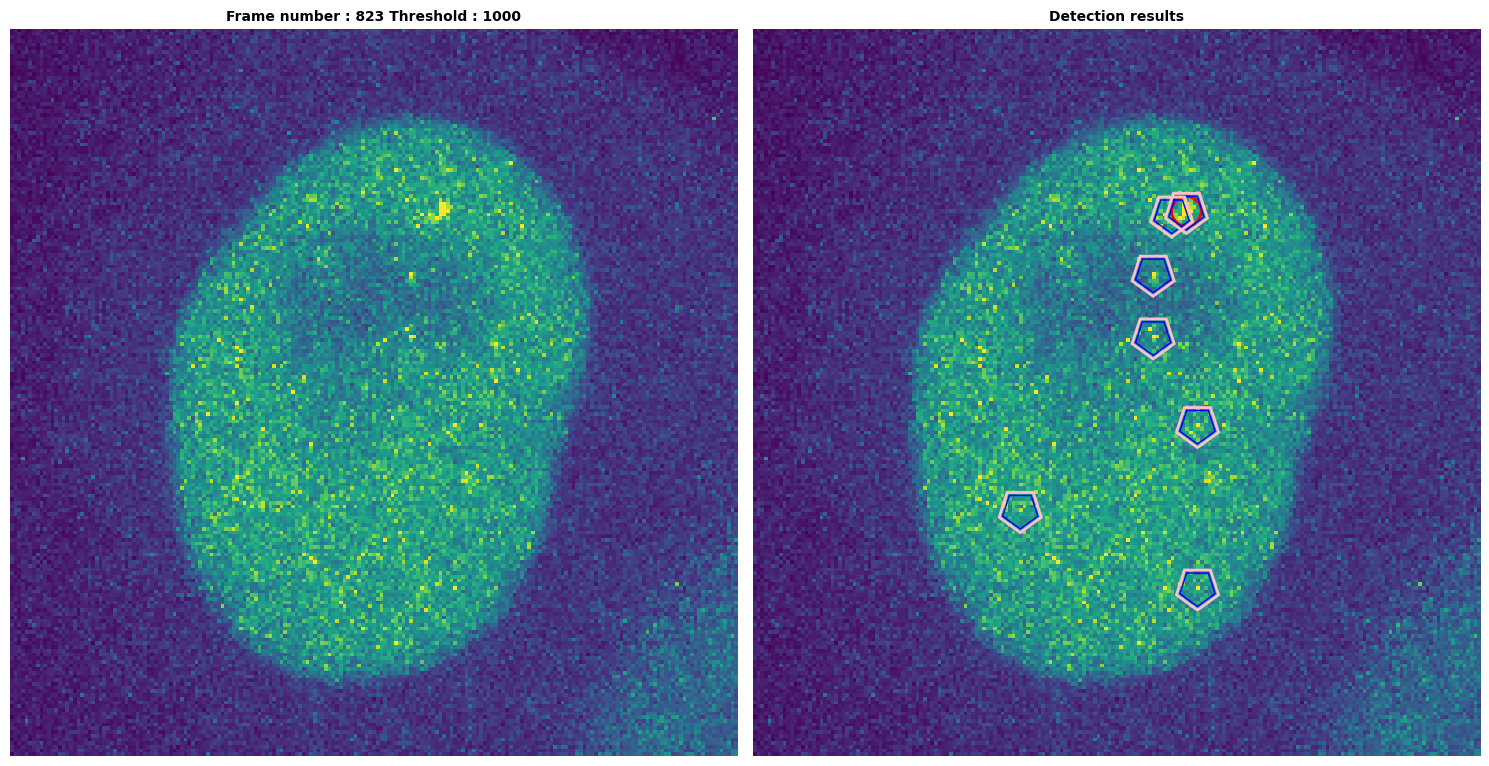

Automatic Threshold (gradient) = 782.0
Automatic Threshold (difference) = 799


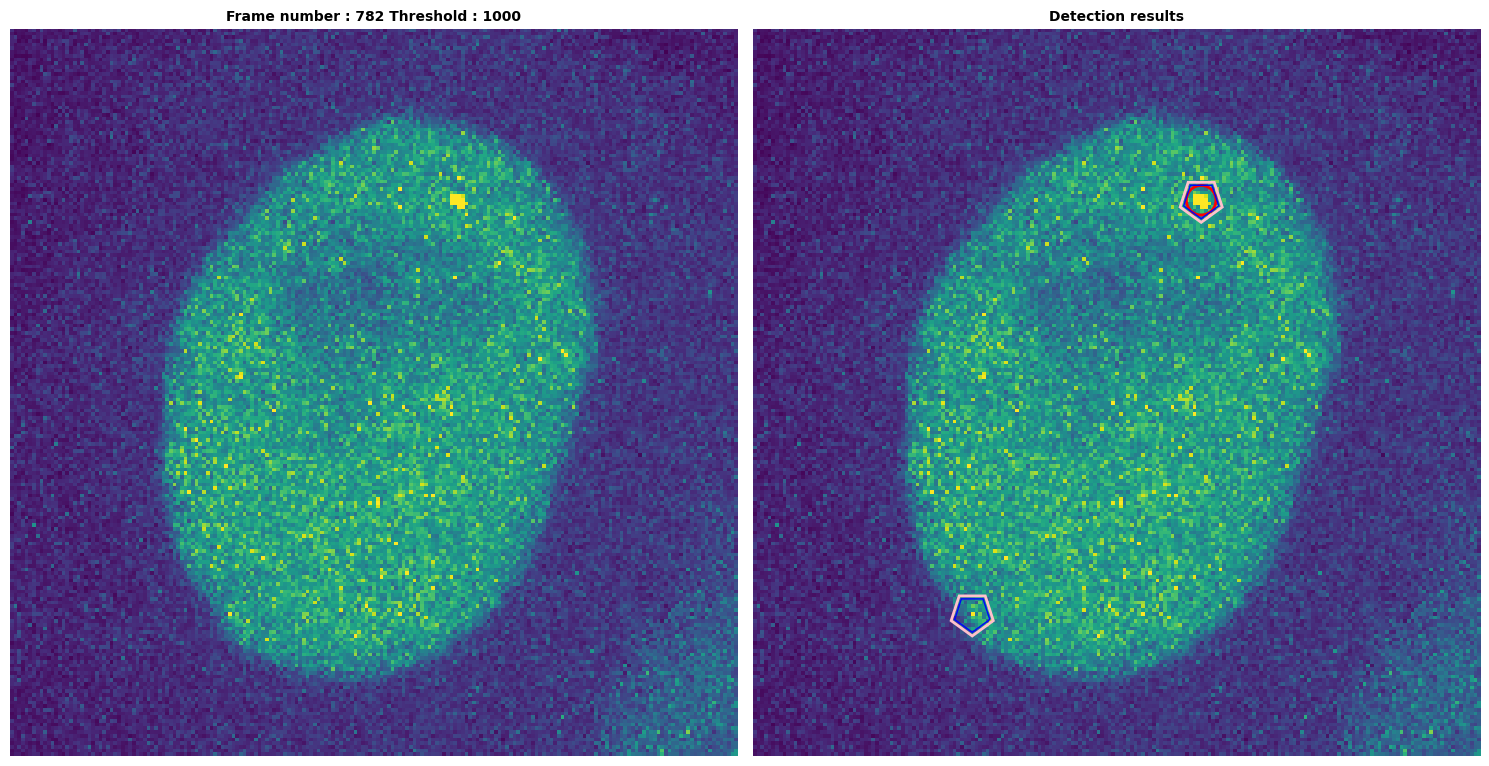

In [154]:

for t in [823,782]:
    path = os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif")
    rna = stack.read_image(path)

    rna_mip = stack.maximum_projection(rna)
    thrs = 1000
#     threshold_image_list=2000
    # spot radius
    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxelRadius,#(600, 80, 80), 
        object_radius_nm=objectRadius, 
        ndim=3)

    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    print('Automatic Threshold (gradient) = '+str(threshold_image_list))
    spots_current, _ = detection.spots_thresholding(rna_log, mask, thrs)
    print('Automatic Threshold (difference) = '+str((kneedle.x[xx])))
    
    spots_currentGrd, _ = detection.spots_thresholding(rna_log, mask, threshold_image_list)
    spots_currentKneedl, _ = detection.spots_thresholding(rna_log, mask, np.float64(kneedle.x[xx]))

    plot.plot_detection(rna_mip, 
                            spots=[spots_current, spots_currentGrd,spots_currentKneedl], 
                            shape=["circle", 'polygon','polygon'], 
                            radius=[4,5,6], 
                            color=["red",'blue','pink'],
                            linewidth=[2,1,2], 
                            fill=[False, False,False],
                            title='Frame number : '+ str(t)+ ' Threshold : '+str(thrs),
                            contrast=True)